In [1]:
import tensorflow as tf

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)
        
        self.discriminator = self.build_discriminator() 
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        validity = self.discriminator(img)
        
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self): 
        
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        
        return Model(img, validity)

    

    
    def train(self, epochs, batch_size=128, sample_interval=50):

        

        (X_train, _), (_, _) = mnist.load_data()
        
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1)) 

        for epoch in tf.range(epochs):
            
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            
            g_loss = self.combined.train_on_batch(noise, valid)
            gen_imgs = self.generator.predict(noise)
            
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
            if epoch % sample_interval == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
                self.sample_images(epoch)
                filename = f'generator_model_{epoch}.h5'
                self.generator.save(filename)
                
                self.g_write_to_txt("g_loss", g_loss)
                
                self.write_to_txt("d_loss_real", d_loss_real)
                self.write_to_txt("d_loss_fake", d_loss_fake)
                self.write_to_txt("d_loss", d_loss)

                
    def write_to_txt(self, filename, number):
        f = open(f"{filename}.txt", "a")
        f.write(str(number[0])+ ' '+str(number[1])+'\n')
        f.close()
        
    
    def g_write_to_txt(self, filename, number):
        f = open(f"{filename}.txt", "a")
        f.write(str(number) + '\n')
        f.close()
        
                

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("img/%d.png" % epoch)
        plt.close()

In [3]:

# gan = GAN()
# gan.train(epochs=100000, batch_size=132, sample_interval=1000 0)


# # 99000 [D loss: 0.590638, acc.: 67.80%] [G loss: 1.156569]

In [4]:
d_loss_real = pd.read_csv('d_loss_real.txt', sep = ' ', header = None, names = ['loss', 'acc'])
d_loss_fake = pd.read_csv('d_loss_fake.txt', sep = ' ', header = None, names = ['loss', 'acc'])
d_loss = pd.read_csv('d_loss.txt', sep = ' ', header = None, names = ['loss', 'acc'])
g_loss = pd.read_csv('g_loss.txt', sep = ' ', header = None, names = ['loss'])

Text(0.5, 1.0, 'Discriminator loss function')

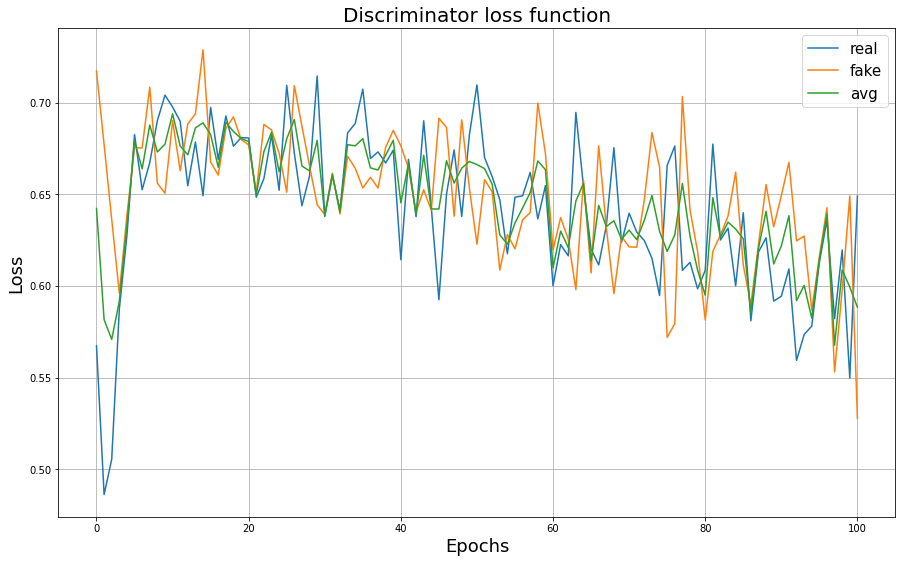

In [5]:
plt.figure(figsize=(15, 9))
d_loss_real['loss'].plot()
d_loss_fake['loss'].plot()
d_loss['loss'].plot()
plt.grid(True)
plt.legend(['real', 'fake', 'avg'], prop={"size":15})
plt.xlabel('Epochs', size = 18)
plt.ylabel('Loss', size = 18)
plt.title('Discriminator loss function', size = 20)

Text(0.5, 1.0, 'Discriminator accuracy')

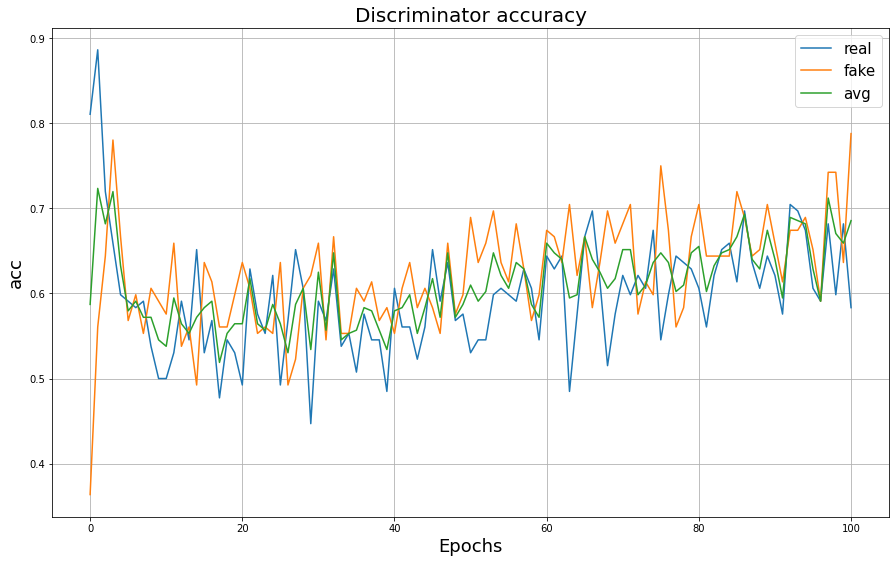

In [6]:
plt.figure(figsize=(15, 9))
d_loss_real['acc'].plot()
d_loss_fake['acc'].plot()
d_loss['acc'].plot()
plt.grid(True)
plt.legend(['real', 'fake', 'avg'], prop={"size":15})
plt.xlabel('Epochs', size = 18)
plt.ylabel('acc', size = 18)
plt.title('Discriminator accuracy', size = 20)

Text(0.5, 1.0, 'Loss function')

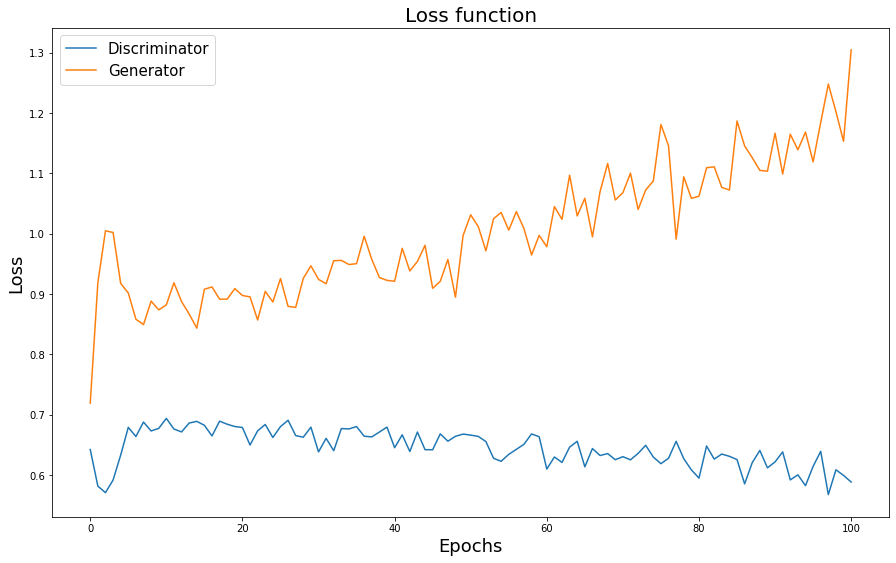

In [7]:
plt.figure(figsize=(15, 9))
d_loss['loss'].plot()
g_loss['loss'].plot()
plt.legend(['Discriminator', 'Generator'], prop={"size":15})
plt.xlabel('Epochs', size = 18)
plt.ylabel('Loss', size = 18)
plt.title('Loss function', size = 20)

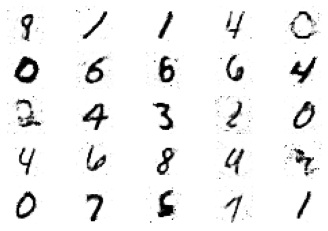

In [8]:

from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


def save_plot(examples, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

    
model = load_model('generator_model_100000.h5')
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
save_plot(X, 5)

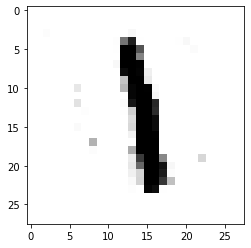

In [9]:

from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
import numpy as np

model = load_model('generator_model_100000.h5')
vector = asarray([np.random.randn(100)])
X = model.predict(vector)

pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()